## Import Packages

In [1]:
from os import listdir
import pandas as pd
import csv
import glob

## Getting the Data sample

In [2]:
# Download the dataset from the challenge page and rename the dataset as training_A and training_B

training_a = sorted(listdir('training_A/'))

training_b = sorted(listdir('training_B/'))

In [4]:
dummy = pd.read_csv('training_A/p000902.psv', sep ='|')
dummy.shape

(44, 41)

## Training Data 

In [8]:
with open("sepsis_data.psv", "wb") as fout:
    
    for i, csv in enumerate(training_a):
        if i == 0:
            with open('training_A/' + csv, "rb") as f:
                fout.write(f.read())
      # now the rest:    
        with open('training_A/' + csv, "rb") as f:
            next(f) 
            fout.write(f.read())
      
    for i,csv in enumerate(training_b):
        if i <15000:
            with open('training_B/' + csv, "rb") as f:
                next(f)
                fout.write(f.read())

In [9]:
sepsis_data = pd.read_csv('sepsis_data.psv', sep ='|')

In [12]:
print(sepsis_data.head())


      HR  O2Sat  Temp    SBP    MAP  DBP  Resp  EtCO2  BaseExcess  HCO3  ...  \
0    NaN    NaN   NaN    NaN    NaN  NaN   NaN    NaN         NaN   NaN  ...   
1   97.0   95.0   NaN   98.0  75.33  NaN  19.0    NaN         NaN   NaN  ...   
2   89.0   99.0   NaN  122.0  86.00  NaN  22.0    NaN         NaN   NaN  ...   
3   90.0   95.0   NaN    NaN    NaN  NaN  30.0    NaN        24.0   NaN  ...   
4  103.0   88.5   NaN  122.0  91.33  NaN  24.5    NaN         NaN   NaN  ...   

   WBC  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
1  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
2  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
3  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
4  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   

   ICULOS  SepsisLabel  
0       1            0  
1       2         

In [11]:
sepsis_data.shape

(1361672, 41)

## Testing Data 

In [15]:
with open("sepsis_data_test.psv", "wb") as fout:
    
    for i, csv in enumerate(training_b):
        if i >= 15000:
            if i == 15000:
                with open('training_B/' + csv, "rb") as f:
                    fout.write(f.read())   
            with open('training_B/' + csv, "rb") as f:
                next(f) 
                fout.write(f.read())
      

In [16]:
test = pd.read_csv('sepsis_data_test.psv', sep='|')

In [17]:
test.shape

(190615, 41)

## Data Analysis

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
#from sklearn_pandas import CategoricalImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

In [56]:
import missingno as msno

In [20]:
sepsis_data.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

## Checking how many patients have Sepsis vs not Sepsis

In [28]:
df = sepsis_data['SepsisLabel'].value_counts()

In [54]:
no_sepsis_percent = (df[0]/(df[0]+df[1]))*100
sepsis_percent = (df[1]/(df[0]+df[1]))*100

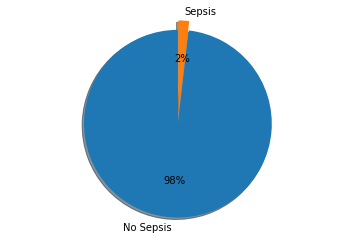

In [53]:
#fig = plt.figure(figsize=(5,5))
labels = 'No Sepsis', 'Sepsis'
sizes = [no_sepsis_percent, sepsis_percent]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode = explode, labels = labels, autopct = '%1.0f%%', shadow=True, startangle = 90)
ax1.axis('equal')



plt.savefig('Saved_Figures/percent_sepsis.png')
plt.show()

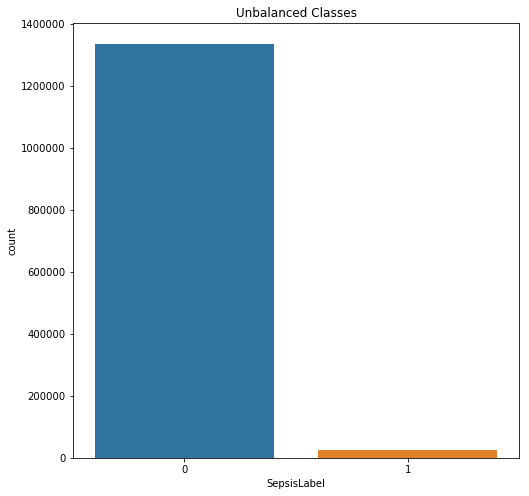

In [17]:
plt.figure(figsize=(8, 8))
sns.countplot('SepsisLabel', data=sepsis_data)
plt.title('Unbalanced Classes')
plt.show()

## Dealing with Imbalance Data - revisit later

### To know about Sepsis

Resource: https://www.healthline.com/health/sepsis#symptoms

There are three stages of sepsis: sepsis, severe sepsis, and septic shock.
Symptoms of Sepsis:
    1. Fever abover 101ºF (38ºC) or below 96.8ºF (36ºC) <- Temp (ºC)
    2. Heart Rate higher than 90 beats per minute <- HR (beats/min)
    3. Breathing rate higher than 20 breaths per min <- Resp (breaths per minute)
    4. Systolic Blood Pressure less than or equal to 100 mm of mercury <- SBP (mm Hg)
    5. Arterial carbon dioxide tension of less than 32 mm Hg < - PaCO2
    6. Abnormal White blood cell count ( >12000/mL or <4000//mL) <- WBC

Symptoms of Severe Sepsis and Septic Shock:
    1. Platlet count is very low i.e below 80,000/mm3 <- Platlets (count*10^3/µL)
    2. Very Low Blood Pressure. i.e less than 65 mm of mercury <- SBP (mm Hg)
    3. Too much of lactic acid in your blood(serum lactate) after you have recieved adaquate fluid replacement. Having too much lactic acid in your blood means that your cells aren't using oxygen properly <- Lactate	Lactic acid (mg/dL)
    

Sepsis is more common if:

1. Age - Infants (age < 5) or old (age > 80) <- Age
2. Weak Immune System
3. Have diabetes <- Contributing factors - Glucode Serum glucose (mg/dL)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4958885/

Interesting information :
    
Septic shock is defined as unrecovered hypotension despite 
adequate fluid replacement in the Surviving Sepsis Campaign (SSC) 
Guidelines

1.  septic shock can be diagnosed under two conditions:
    - The first condition is persistent hypotension after 
    fluid resuscitation and requiring vasopressors to 
    maintain MAP >65 mmHg. 
    - The second condition is serum lactate level >2 mmol/L. 
    
increased serum lactate level may represent tissue hypoperfusion 
associated with signs of organ dysfunction in critically ill patients
serum lactate level is found to be > 2 mmol/L



### Contribution of Heart rate to sepsis?

- In normal situations, heart rate varies, indicating the heart's 
capacity to adapt to different situations. HRV measures the 
oscillation of the intervals between consecutive heart beats, 
which are related to, the influences of the autonomic nervous 
system on the sinus node.

-  Patients with sepsis have reduced HRV compared to healthy patients,
as demonstrated in small studies